# Path and shape regimes of rising bubbles

## Outline

1. [Starting point](#starting_point)
2. [Data visualization](#data_visualization)
3. [Manual binary classification - creating a functional relationship](#manuel_classification)
4. [Using gradient descent to find the parameters/weights](#gradient_descent)
5. [Using conditional probabilities instead of binary classes](#conditional_probabilities)
6. [Maximum likelihood and cross-entropy](#maximum_likelihood)
7. [Non-linear decision boundaries](#non_linear_boundaries)
8. [The multi-layer perceptron](#multi_layer_perceptron)
9. [Multi-class classification](#multi_class)
    1. [One-hot encoding](#one_hot)
    2. [Softmax function](#softmax)
    3. [Categorial cross-entropy](#categorial_cross_entropy)
    4. [A note on the implementation in PyTorch](#note_on_pytorch)
10. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

Our goal is to predict the path and shape regime of rising bubbles depending on the Eötvös and Galilei number defined as

$$
  Ga = \frac{\sqrt{gR}R}{\nu},\quad \text{and}\quad Eo = \frac{\rho gR^2}{\sigma},
$$

with the variables being $g$ - gravitational constant, $\nu$ - kinematic liquid viscosity, $\rho$ - liquid density, and $R$ - equivalent sphere radius. The Galilei number relates interia, buoyancy, and viscous forces. The Eötvös number relates buoyancy and surface tension forces. The path and shape regimes encountered in the range $Ga\in \left[0, 800\right]$ and $Eo\in \left[0,500\right]$ are:

1. axis-symmetric shape, straight rise
2. asymmetric shape, non-oscillatory rise
3. asymmetric shape, oscillatory rise
4. peripheral breakup
5. central breakup

What we want to do is to find a function that takes $Ga$ and $Eo$ as arguments and maps them to one of the regimes listed above. All we have to build such a function are only some examples of given $Ga$ and $Eo$ and the corresponding regime. In machine-learning terminology,

- the function arguments are called **features**, and
- the expected function output (value) is called **label**.

**Why would we want such a classifier?**

In an abstract sense, one can use such a classifier function to automate decision processes or to combine several smaller algorithms to leverage their collective performance (accuracy, applicability, execution time, etc.). If that explanation was too abstract, here are two more illustrative scenarios:

* The goal is to design a multiphase reactor. The reactor ought to operate in a homogeneous regime. For a given liquid, you want to estimate how large the bubbles sparged into the reactor can be to rise on a non-oscillatory path. Of course, the size could be determined graphically from a plot, but if the process is to be automated (e.g., in a software), a functional relationship between size and regime is required.
* In a real bubble column reactor, bubble paths from all kinds of regimes will occur. In a scale-reduced simulation of such a reactor, closure models have to be defined, e.g., the drag coefficient in an Euler-Lagrange solver. The standard approach would be to use the correlation by *Schiller and Naumann* (particles) or by *Tomiyama* (bubbles). Presumably, the correlations will be used far outside their actual range of validity, but actually, there are many more correlations available for smaller sub-regimes. The classifier can be used to build a unified correlation covering a much broader parameter range with higher accuracy by automatically switching between different suitable correlations.

The following data was extracted from figure 1 in [Tripathi et al.](https://www.nature.com/articles/ncomms7268)
> Tripathi, M. K. et al. Dynamics of an initially spherical bubble rising in quiescent liquid. Nat. Commun. 6:6268 doi: 10.1038/ncomms7268 (2015)

In general, it would be sensible to gather data from as many sources as possible. The data could also be contradictory, e.g., close to decision boundaries. Most classification algorithms are robust enough to handle such data by drawing decision boundaries according to the *majority*.

In [1]:
# load and process .csv files
import pandas as pd
# python arrays
import numpy as np
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# machine learning
import sklearn
from sklearn import preprocessing
import torch
from torch import nn, optim
import torch.nn.functional as F
# display images in notebook and make some plots interactive
from IPython.display import HTML, display
from ipywidgets import interact
# Define Dataset and dataset loader
from torch.utils.data import Dataset, DataLoader
# for splitting data to trainvalidation data
from torch.utils.data import random_split

# some settings for plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
rc('text', usetex=True)
markers = ["o", "x", "<", ">", "*"]
fontsize_label = 14
figsize = (8, 5)
save_figures = True

def conditional_save(file_name):
    if save_figures:
        plt.savefig(file_name, bbox_inches="tight")

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("ScikitLearn version: {}".format(sklearn.__version__))
print("PyTorch version: {}".format(torch.__version__))

Pandas version: 1.2.2
Numpy version: 1.19.5
ScikitLearn version: 0.24.1
PyTorch version: 1.7.1+cpu


In [2]:
data_path = "../data/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = ["regime_{}.csv".format(regime) for regime in regimes]
files = [pd.read_csv(data_path + file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for file, regime in zip(files, regimes):
    file["regime"] = regime
data = pd.concat(files, ignore_index=True)
print("Read {} data points".format(data.shape[0]))
data.sample(5)

Read 103 data points


,Ga,Eo,regime
11,22.3750,0.10129,I
77,50.7710,192.94000,V
9,10.0087,20.35100,I
61,31.8190,38.60700,IV
46,6.9390,39.24600,III


In [3]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


## Data visualization<a id="data_visualization"></a>
 
Let's have a look at the raw data loaded from the files.

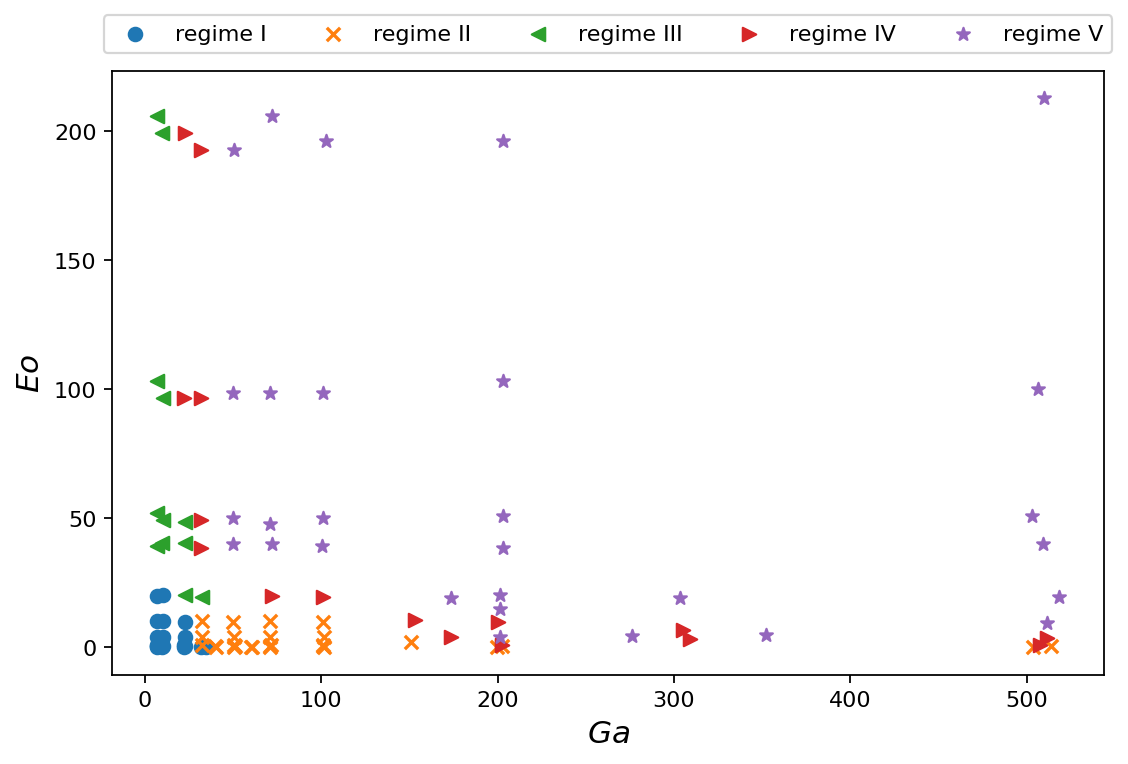

In [4]:
plt.figure(figsize=figsize)
for regime, marker in zip(regimes, markers):
    plt.scatter(data[data["regime"] == regime].Ga, data[data["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5)
plt.xlabel(r"$Ga$", fontsize=fontsize_label)
plt.ylabel(r"$Eo$", fontsize=fontsize_label)
conditional_save("path_data_raw_scatter.svg")
plt.show()

The figure above is visually not very appealing. In some regions, data points are really dense while other portions of the figure are almost empty. We can also visualize this nonuniform distribution of data in the feature space by means of histograms.

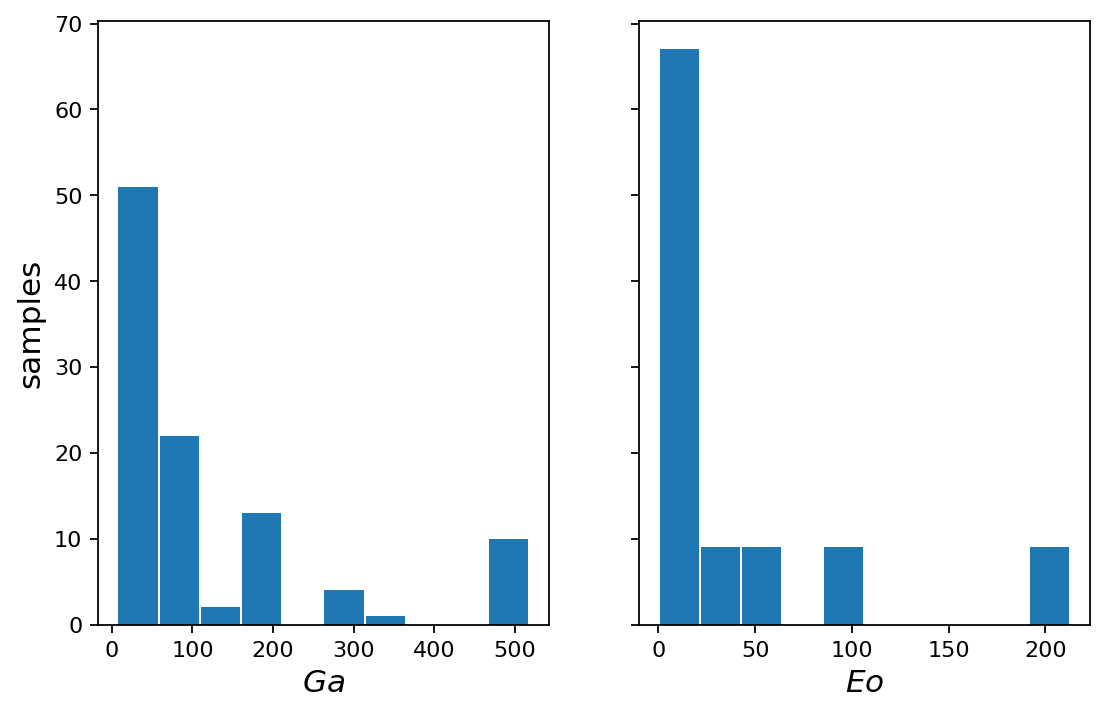

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
ax1.hist(data.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga$", fontsize=fontsize_label)
ax1.set_ylabel(r"samples", fontsize=fontsize_label)
ax2.hist(data.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo$", fontsize=fontsize_label)
conditional_save("path_data_raw_hist.svg")
plt.show()

To obtain clear stability regions as in figure 1 of the article referenced above, we will work with the **logarithm** of the features $Ga$ and $Eo$ instead of the features themselves. Such a pre-processing step is typical for most machine learning application since many algorithms are sensitive to the scale of the features (some algorithms perform poorly if one feature ranges, say, from $0$ to $0.1$ while another one ranges from $0$ to $1000$). The logarithmic scaling also stretches the original feature space for small values and compresses it for large values such that the overall data distribution in the transformed feature space is much more uniform.

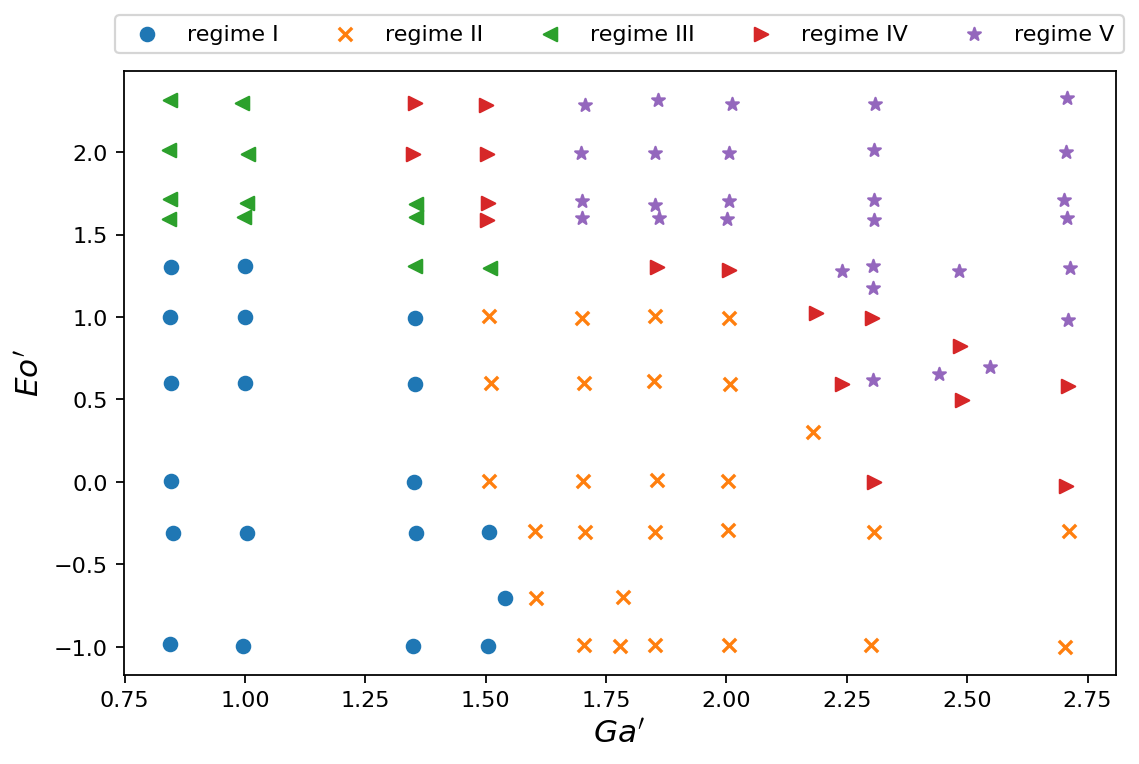

In [6]:
logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

plt.figure(figsize=figsize)
for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5)
plt.xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
plt.ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("path_data_log_scatter.svg")
plt.show()

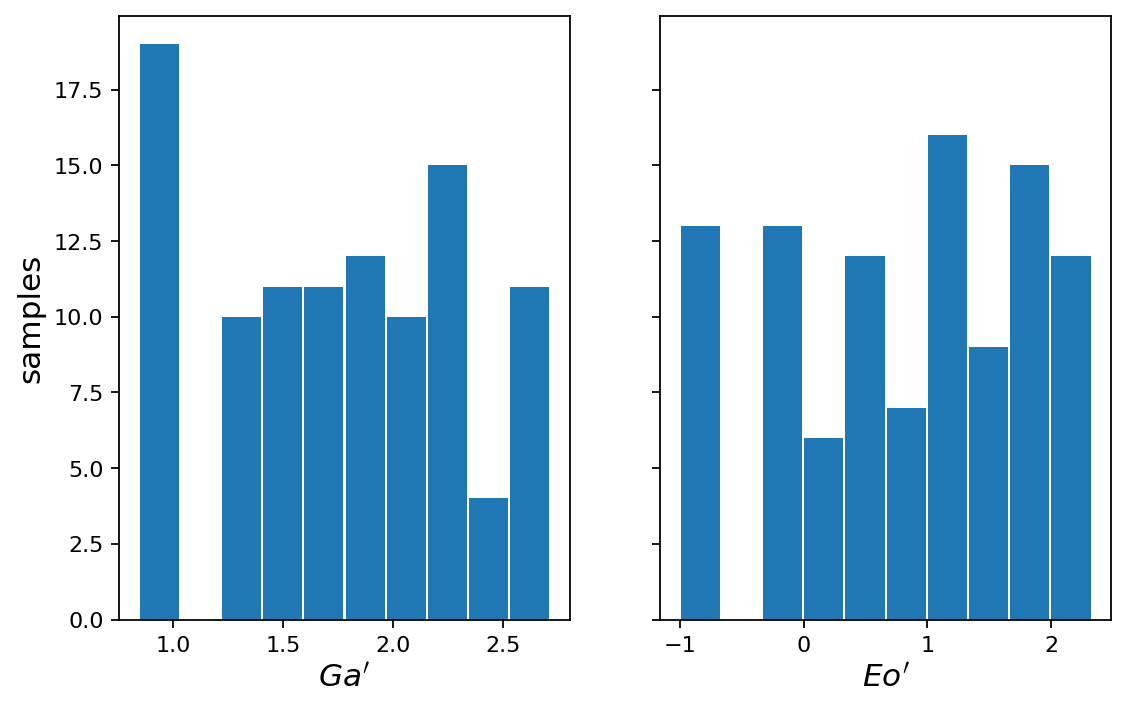

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
ax1.hist(logData.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
ax1.set_ylabel(r"samples", fontsize=fontsize_label)
ax2.hist(logData.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("path_data_log_hist.svg")
plt.show()

## Manuel binary classification - creating a functional relationship<a id="manuel_classification"></a>

First, we create a classifier by hand (trail and error). To simplify things, we focus only on regimes I and II. From the plot above, the data points of regions I and II look almost linearly separable. Therefore, we will define a linear function $z(Ga^\prime, Eo^\prime) = w_1Ga^\prime + w_2Eo^\prime + b$ with the transformed features $Ga^\prime = log(Ga)$ and $Eo^\prime = log(Eo)$ and build a classifier that distinguishes the cases

$$
H(z) = \left\{\begin{array}{lr}
    0, & \text{if } z \leq 0\\
    1, & \text{if } z \gt 0
    \end{array}\right.
$$

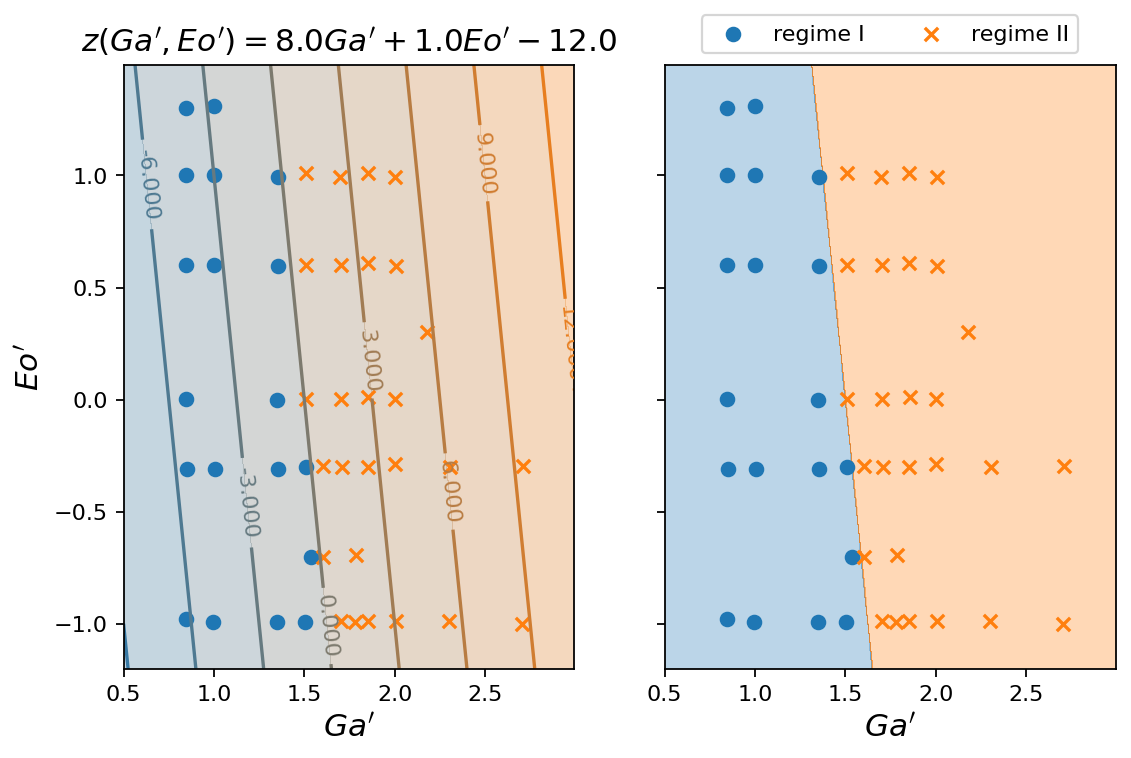

<function __main__.plot_regime_prediction(w1, w2, b)>

In [8]:
resolution = 0.005 # resolution for plotting region contours

def z_func(logGa, logEo, w1, w2, b):
    '''Compute a weighted linear combination of logGa and logEo.
    '''
    #w1 = 8.0; w2 = 1; b = -12
    return w1 * logGa + w2 * logEo + b


def H_func(logGa, logEo, w1, w2, b):
    '''Distinguish between z<=0 and z>0.
    '''
    return np.heaviside(z_func(logGa, logEo, w1, w2, b), 0.0)
    
def plot_regime_prediction(w1, w2, b):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
    xx, yy = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 1.5, resolution))
    weighted_sum = z_func(xx.ravel(), yy.ravel(), w1, w2, b)
    prediction = np.heaviside(weighted_sum, 0.0)
    cm = LinearSegmentedColormap.from_list("blue_to_orange", ['C0', 'C1'], 20)
    ax1.contourf(xx, yy, weighted_sum.reshape(xx.shape),cmap=cm, alpha=0.3)
    CS = ax1.contour(xx, yy, weighted_sum.reshape(xx.shape), cmap=cm)
    ax1.clabel(CS, inline=1, fontsize=10)
    ax2.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
    for regime, marker in zip(regimes[:2], markers[:2]):
        ax1.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                    marker=marker, label="regime {}".format(regime))
        ax2.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                    marker=marker, label="regime {}".format(regime))
    ax1.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
    ax2.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
    ax1.set_ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
    ax1.set_title(r"$z(Ga^\prime, Eo^\prime) = {:1.1f}Ga^\prime + {:1.1f}Eo^\prime {:1.1f}$".format(w1, w2, b), fontsize=fontsize_label)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    conditional_save("manual_binary_classification.svg")

interact(plot_regime_prediction, w1=(6, 10, 1), w2=(-1, 3, 1), b=(-14, -10, 1))

The classifier predicts points of regions I and II in the data set correctly. But there is some space for improvement:

* we had to figure out the parameters $w_1,w_2,b$ for $z$ manually by trial and error
* the decision boundary does not always look ideal; since we do not know the true decision boundary but only some data points, it would be reasonable to search for a boundary which maximizes the distance to the points closest to the boundary
* if we include more regimes, it will become more and more challenging if not impossible to separate the different regions
* the approach only works well for linearly separable data

## Using gradient descent to find the parameters/weights<a id="gradient_descent"></a>

In the previous section, we manually searched for the slope and offset of a linear function to separate the two classes. This process can be automated by defining and solving an optimization problem. One option would be to define a loss function which expresses the prediction quality. Since we are dealing with functions that the computer has to evaluate, it makes sense to convert the different regimes into numeric values. Let's say the value of our numeric label $y$ is $0$ for region I and $1$ for region II (referred to as binary encoding). The true label $y_i$ is known for all points $i$ in the data set. The predicted label $\hat{y}_i$ depends on $z_i$, and therefore, on the weights $\mathrm{w} = \left[w_1, w_2, b\right]$ and the feature vector $\mathrm{x}_i=\left[Ga^\prime_i,Eo^\prime_i \right]$. A common loss is the squared difference of true and predicted label $(y-\hat{y})^2$ for all $N$ data points:

$$
  L(\mathrm{w}) = \frac{1}{2}\sum\limits_{i=1}^N \left(y_i - \hat{y}_i(\mathrm{x}_i,\mathrm{w}) \right)^2
$$

The pre-factor $1/2$ is only for convenience, as will become clear later on. Without the pre-factor, the loss function is nothing but the number of miss-predictions. The knobs we can turn to minimize the loss are the weights $\mathrm{w}$. The most common algorithm to find suitable weights in machine learning is called gradient descent. The idea is to compute the gradient of the loss function w.r.t. the weights and then to change the weights in small steps in negative gradient direction. The gradient of $L$ is

$$
  \frac{\partial L}{\partial \mathrm{w}} =
  \begin{pmatrix}\frac{\partial L}{\partial w_1}\\
                 \frac{\partial L}{\partial w_2}\\
                 \frac{\partial L}{\partial b}
  \end{pmatrix}=
  -\frac{1}{2}\sum\limits_{i=1}^N 2\left(y_i - \hat{y}_i(\mathrm{x}_i,\mathrm{w}) \right) \frac{\partial \hat{y}_i(\mathrm{x}_i,\mathrm{w})}{\partial \mathrm{w}} =
  -\sum\limits_{i=1}^N \left(y_i - \hat{y}_i(\mathrm{x}_i,\mathrm{w}) \right) \delta 
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix},
$$

with the partial derivate of $\hat{y}_i(\mathrm{x}_i,\mathrm{w})$ being

$$
  \frac{\partial \hat{y}_i(\mathrm{x}_i,\mathrm{w})}{\partial \mathrm{w}} = \delta
  \begin{pmatrix}\frac{\partial}{\partial w_1} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial w_2} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial b} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)
  \end{pmatrix} = \delta
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

The derivative of the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function), used in the classifier, is the [Dirac distribution](https://en.wikipedia.org/wiki/Dirac_delta_function), which evaluates to one in each point $i$ in the equations above. To update the weights, we change the weights in negative gradient direction by a small fraction of the gradient. The **learning rate** $\eta$ determines how small or large the weight updates are. The formula to update the weights is

$$
  \mathrm{w}^{n+1} = \mathrm{w}^n - \eta \frac{\partial L(\mathrm{w})}{\partial \mathrm{w}} =
  \begin{pmatrix}w_1^n\\
                 w_2^n\\
                 b^n
  \end{pmatrix} + \eta
  \sum\limits_{i=1}^N \left(y_i - \hat{y}_i(\mathrm{x}_i,\mathrm{w}^n) \right)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}
$$

In [9]:
class SimpleClassifier():
    '''Implementation of a simple *perceptron* and the perceptron learning rule.
    '''
    def __init__(self, eta=0.01, epochs=1000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < 1.0E-6:
                print("Training converged after {} epochs.".format(e))
                break
        
    def loss(self, X, y):
        return 0.5 * np.sum(np.square(y - self.predict(X)))
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.predict(X))
    
    def predict(self, X):
        return np.heaviside(np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_), 0.0)

In [10]:
# create reduced data set with regimes I and II and train classifier
reducedData = logData[(logData.regime == "I") | (logData.regime == "II")]
lb = preprocessing.LabelBinarizer() # the LabelBinarizer converts the labels "I" and "II" to 0 and 1
lb.fit(reducedData.regime)
y = lb.transform(reducedData.regime).ravel() # label tensor
X = reducedData[["Ga", "Eo"]].values # feature tensor

classifier = SimpleClassifier()
classifier.train(X, y)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 41 epochs.
Computed weights: w1=0.4783, w2=0.0435, b=-0.7203


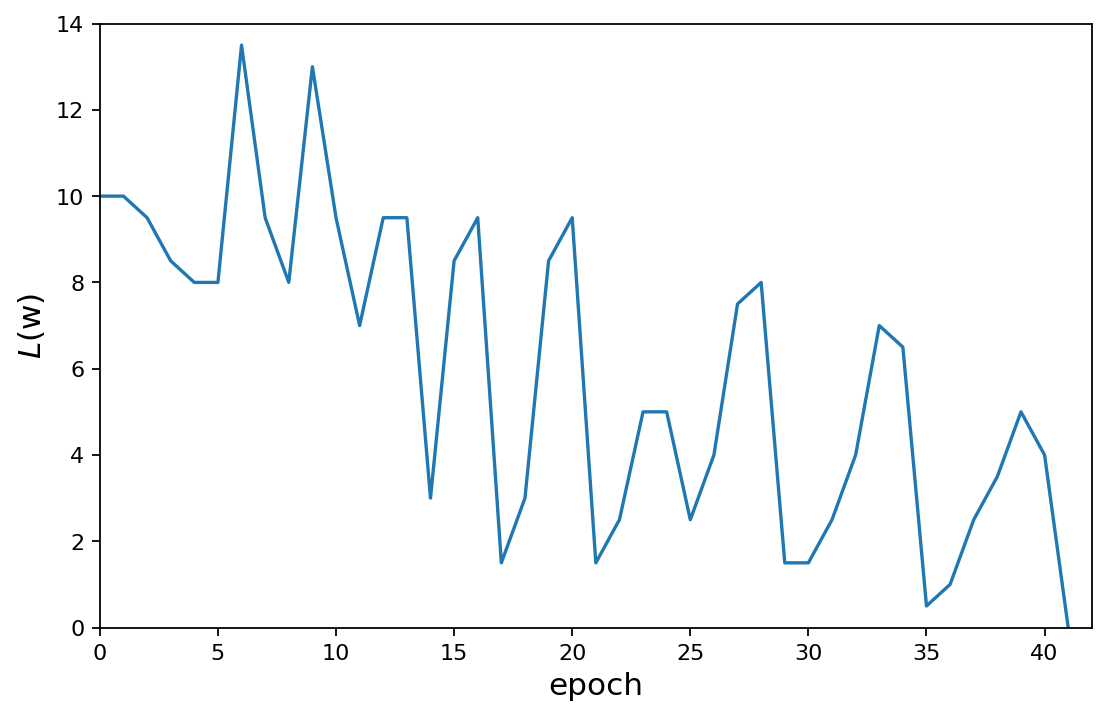

In [11]:
# plot loss over epochs
plt.figure(figsize=figsize)
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize_label)
plt.ylabel(r"$L(\mathrm{w})$", fontsize=fontsize_label)
plt.xlim(0, len(classifier.loss_))
plt.ylim(0, 14)
conditional_save("perceptron_loss.svg")
plt.show()

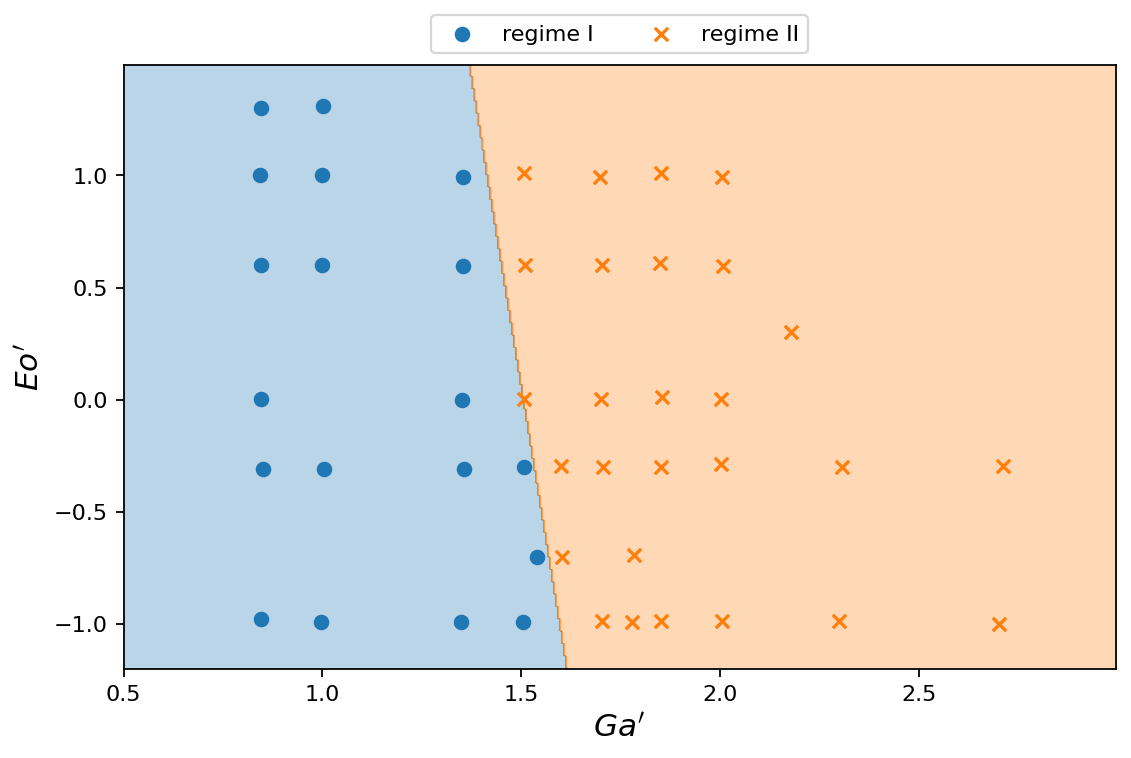

In [12]:
xx, yy = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 1.5, resolution))

plt.figure(figsize=figsize)
prediction = classifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
plt.ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("perceptron_classification.svg")
plt.show()

Gradient descent is the standard algorithm in machine learning to determine parameters, e.g., of neural networks. The trained classifier learned to predict all points in the training set correctly. However, the result is still not satisfying in that

* the placement of the final decision boundary could be better,
* the loss does not decrease monotonously because the loss function is not continuous (this cloud lead to convergence problems), and
* the algorithm will undoubtedly fail to converge if the data is non linearly separable.

## Using conditional probabilities instead of binary classes<a id="conditional_probabilities"></a>

To overcome the convergence issues, we need a smooth loss function. The key idea to create smooth loss functions is to consider the odds for a point in the feature space to belong to a certain class instead of making a unique prediction. Before, we used the Heaviside function with $0$ corresponding to region I and $1$ corresponding to region II. Instead, we could consider the probability $p$ for a point to be in region II. Probabilities have values between zero and one.

In the case of binary classification, the probabilities of both classes together add up to one. For example, a point very far in the orange region in the figure above should have a probability close to one to be orange and a probability close to zero to be blue. In contrast, a point very far in the blue region should have a probability close to zero to be orange and close to one to be blue. A point very close to the decicion boundary should have a probability around $0.5$ for both classes. Note that the probability for a point to be in region I is the same as for not being in region II.

Before, we used the weighted sum of our features, $z$, to describe whether a point is in region I or II. A negative $z$ led to a point being classified as region I, while a positive $z$ corresponded to region II. Now we have to find a way to convert $z$ into probabilities. There are some requirements which such a transformation function should fulfill:

1. it should map any argument to a positive real number because probabilities are always positive
2. the positive real number should be in the range $0...1$
3. it should be differentiable and monotonous because we want to apply gradient descent

These requirements are met, for example, by the sigmoid function $\sigma (z) = \frac{1}{1+e^{-z}}$.

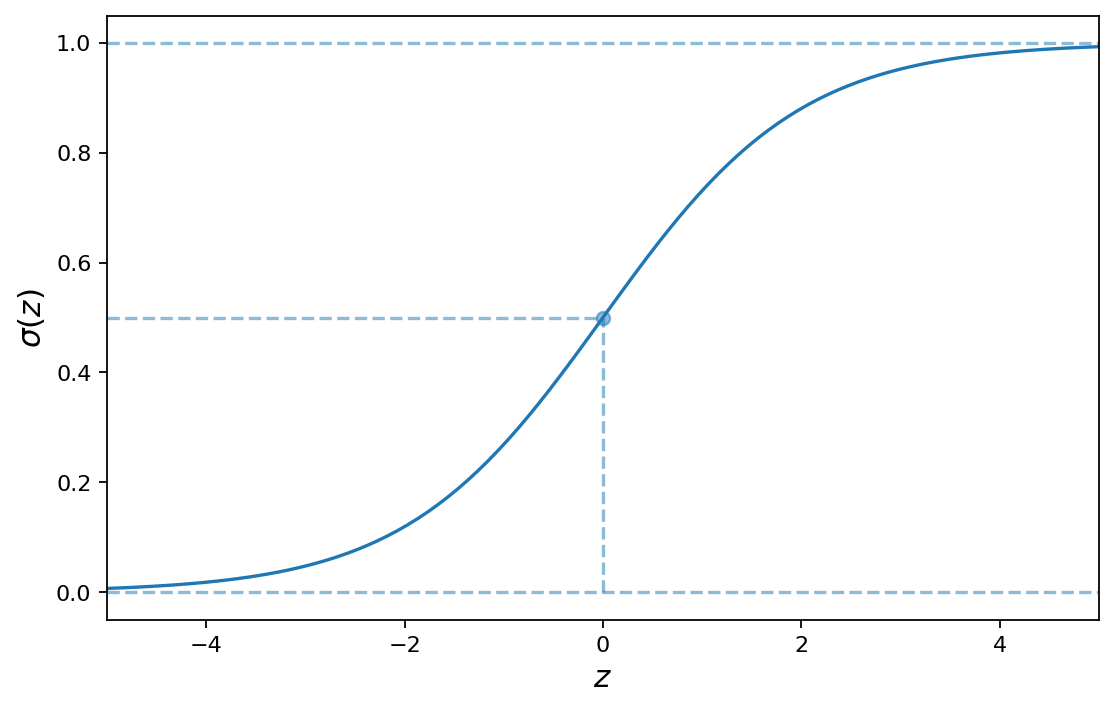

In [13]:
def sigmoid(z):
    '''Compute the sigmoid function.
    '''
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=figsize)
plt.plot(np.linspace(-5, 5, 100), sigmoid(np.linspace(-5, 5, 100)))
plt.scatter([0.0], [0.5], marker="o", alpha=0.5)
plt.vlines(0.0, 0.0, 0.5, "C0", "--", alpha=0.5)
plt.hlines([0.0, 0.5, 1.0], [-5, -5, -5], [5, 0, 5], "C0", "--", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-0.05, 1.05)
plt.xlabel(r"$z$", fontsize=fontsize_label)
plt.ylabel(r"$\sigma (z)$", fontsize=fontsize_label)
conditional_save("sigmoid_function.svg")
plt.show()

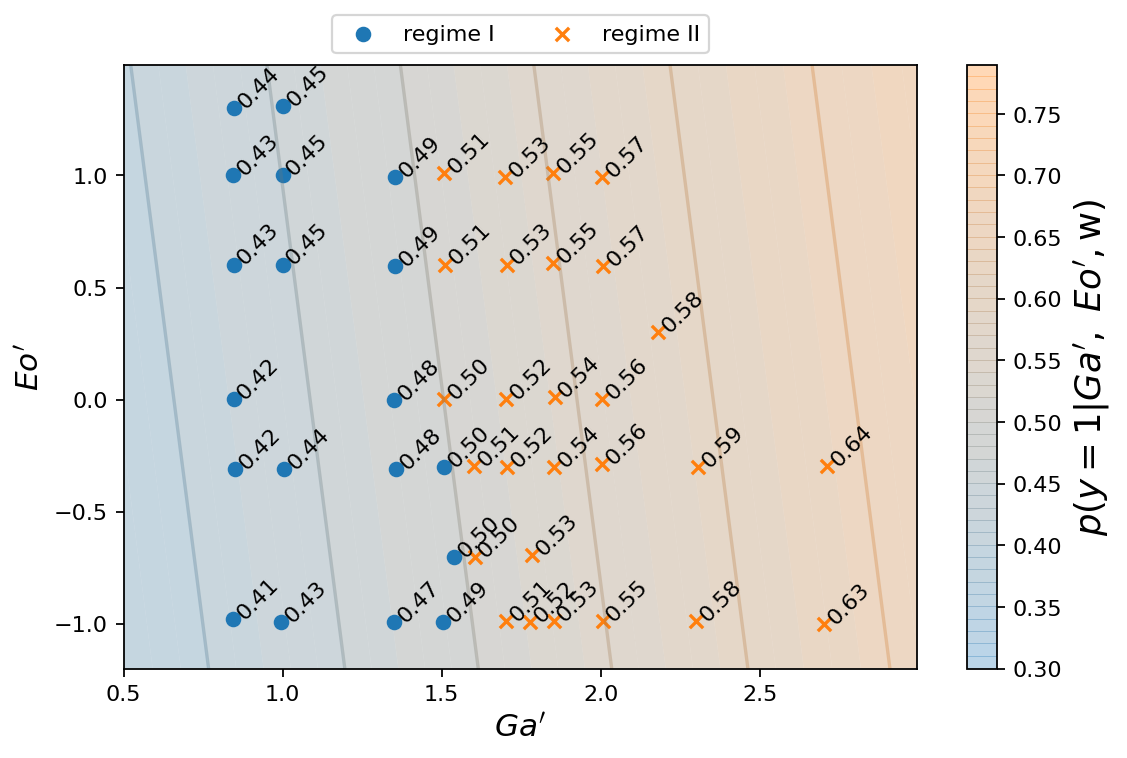

In [14]:
def probability(X, w):
    '''Compute to probability for the features X to be in region II.
    '''
    z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), w)
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=figsize)
cm = LinearSegmentedColormap.from_list("blue_to_orange", ['C0', 'C1'], 20)
prob = probability(np.vstack((xx.ravel(), yy.ravel())).T, classifier.weights_)
plt.contour(xx, yy, prob.reshape(xx.shape),levels=np.arange(0.3, 0.8, 0.05), cmap=cm, alpha=0.3, antialiased=True)
plt.contourf(xx, yy, prob.reshape(xx.shape),levels=np.arange(0.3, 0.8, 0.01), cmap=cm, alpha=0.3, antialiased=True)
plt.colorbar().set_label(r"$p(y=1 | Ga^\prime,\ Eo^\prime, \mathrm{w})$", fontsize=16)

for regime, marker in zip(regimes[:2], markers[:2]):
    Xr = reducedData[reducedData["regime"] == regime][["Ga", "Eo"]].values
    point_prob = probability(Xr, classifier.weights_)
    for i, p in enumerate(Xr):
        plt.annotate("{:.2f}".format(point_prob[i]), (p[0], p[1]), rotation=45)
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
plt.ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("conditional_probabilities.svg")
plt.show()

## Maximum likelihood and cross-entropy<a id="maximum_likelihood"></a>

In the previous step, we reformulated our model $f_\mathrm{w}$ to predict the probability for $y=1$:

$$ \hat{y} = f_\mathrm{w}(Ga^\prime, Eo^\prime) = p(y=1 | Ga^\prime, Eo^\prime, \mathrm{w}). $$

Now we want to use the given training data to find suitable model weights. The joint probability to observe all points in the training set is the product of the individual probabilities. This function is also called likelihood function ([read more](https://web.stanford.edu/class/archive/cs/cs109/cs109.1192/reader/11%20Parameter%20Estimation.pdf) on some of the assumptions):

$$l(\mathrm{w}) = \prod\limits_i^{N} p_i(y_i | \mathrm{x}_i, \mathrm{w}),$$

with $\mathrm{x} = \left[Ga^\prime, Eo^\prime\right]$. The model weights we would like to find maximize the likelihood (hence maximum likelihood principle):

$$ \mathrm{w}^* = \underset{\mathrm{w}}{\mathrm{argmax}}\ l(\mathrm{w}). $$

Currently, our model predicts the probability for a point  to be in region II $\hat{y} = f_{\mathrm{w}}(\mathrm{x}) = p(y=1 | \mathrm{x}, \mathrm{w})$. However, since there only two possible outcomes, the probability for a point to be in region I must be $1-\hat{y} = p(y=0 | \mathrm{x}, \mathrm{w})$. This connections helps us to rewrite $l(\mathrm{w})$ in terms of the model prediction:

$$ l(\mathrm{w}) =  \prod\limits_i^{N} \left[ \hat{y}_i^{y_i} (1-\hat{y}_i)^{(1-y_i)} \right]$$

Instead of maximizing the likelihood, it is numerically more favorable to minimize instead the negative logarithm of $l$. Applying the logarithm has several effects, namely that

1. the product becomes a summation since $\mathrm{ln}(ab) = \mathrm{ln}(a) + \mathrm{ln}(b)$,
2. the label becomes a pre-factor instead of an exponent since $\mathrm{ln}(a^b) = b\mathrm{ln}(a), and$
2. the maximization becomes a minimization problem.

Moreover, we apply two small teaks: we normalize with the number of samples to make the loss values somewhat more independent from the number of samples, and we use the negative logarithms since the logarithm of probabilities is by definition negative. The resulting function is called *binary cross-entropy*. 

$$
  L(\mathrm{w}) = -\frac{1}{N}\sum\limits_{i=1}^N y_i \mathrm{ln}(\hat{y}_i) + (1-y_i) \mathrm{ln}(1-\hat{y}_i)
  \quad \text{with} \quad \hat{y}_i = f_\mathrm{w}(\mathrm{x}_i) = \sigma (z(\mathrm{x}_i, \mathrm{w})).
$$

Note that for each point $i$ only one of the terms in the sum contributes to the loss since $y_i\in \{0,1\}$. High probabilities $\hat{y}_i$ will lead to a small cross entropy. Therefore, minimizing the cross-entropy is the same as maximizing the likelihood of all points to be classified correctly, and we can use this minimization problem as a criterion to adjust the model's weights $\mathrm{w}$.

As before, gradient descent is a suitable algorithm to solve the optimization problem. Since our model $f_\mathrm{w}$ is still rather simple, we can compute the loss gradient by hand:

$$
  \frac{\partial L(\mathrm{w})}{\partial \mathrm{w}} = -\frac{1}{N}\sum\limits_{i=1}^N
  \frac{y_i}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial \mathrm{w}}
  + \frac{1-y_i}{1-\hat{y}_i} \left( -\frac{\partial \hat{y}_i}{\partial \mathrm{w}} \right)
$$

with the partial derivative of the classifier w.r.t. the weights being

$$
  \frac{\partial\hat{y}_i}{\partial \mathrm{w}} = \frac{\partial \sigma}{\partial z_i} \frac{\partial z_i}{\partial \mathrm{w}} =
  \sigma (z_i) (1-\sigma (z_i))
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix} = 
  \hat{y}_i (1-\hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Combining the above equations results in

$$
  \frac{\partial L}{\partial \mathrm{w}} = -\frac{1}{N}\sum\limits_{i=1}^N (y_i - \hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Some hints if you want to understand the computation in all details:

$$
  \frac{\mathrm{d}}{\mathrm{d}x}\mathrm{ln}(x) = \frac{1}{x},\quad
  \frac{\mathrm{d}}{\mathrm{d}x}\sigma(x) = \sigma (x)(1-\sigma (x)),\quad
  \frac{\mathrm{d} f(g(x))}{\mathrm{d} x} = \frac{\mathrm{d}f}{\mathrm{d}g}\frac{\mathrm{d}g}{\mathrm{d}x}
$$

Finally, we need to convert the predicted probability into an actual class (label). As mentioned before, points close the decision boundary have a probability close to $0.5$. So we could say points with $\hat{y} \le 0.5$ belong to region I and points with $\hat{y} > 0.5$ belong to region II. Now we are ready to implement our improved classifier.

In [15]:
class LogClassifier():
    '''Implemention of a logistic-regression classifier.
    '''
    def __init__(self, eta=1.0, epochs=10000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y, tol):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < tol:
                print("Training converged after {} epochs.".format(e))
                break
    
    def loss(self, X, y):
        logProb = y * np.log(self.probability(X)) + (1.0 - y) * np.log(1.0 - self.probability(X))
        return - np.mean(logProb)
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.probability(X)) / X.shape[0]
    
    def probability(self, X):
        z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_)
        return 1.0 / (1.0 + np.exp(-z))
    
    def predict(self, X):
        return np.heaviside(self.probability(X) - 0.5, 0.0)

In [16]:
logClassifier = LogClassifier()
logClassifier.train(X, y, tol=0.1)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 3025 epochs.
Computed weights: w1=0.4783, w2=0.0435, b=-0.7203


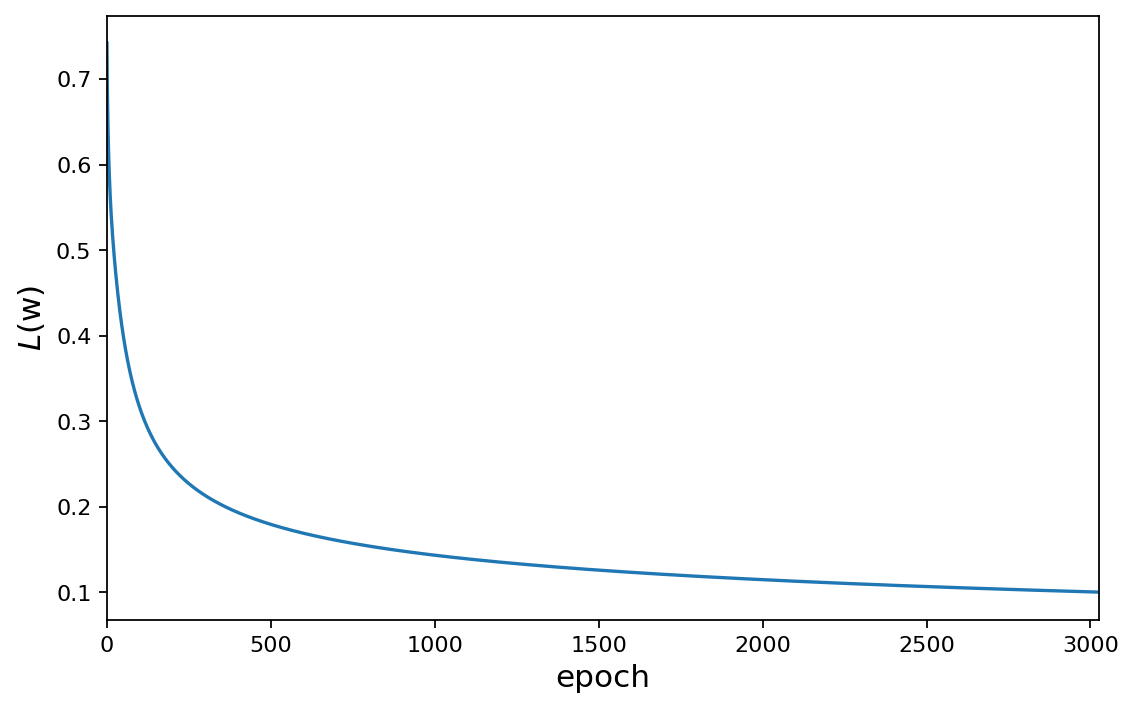

In [17]:
# plot loss over epochs
plt.figure(figsize=figsize)
plt.plot(range(len(logClassifier.loss_)), logClassifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize_label)
plt.ylabel(r"$L(\mathrm{w})$", fontsize=fontsize_label)
plt.xlim(0.0, len(logClassifier.loss_))
conditional_save("log_regression_loss.svg")
plt.show()

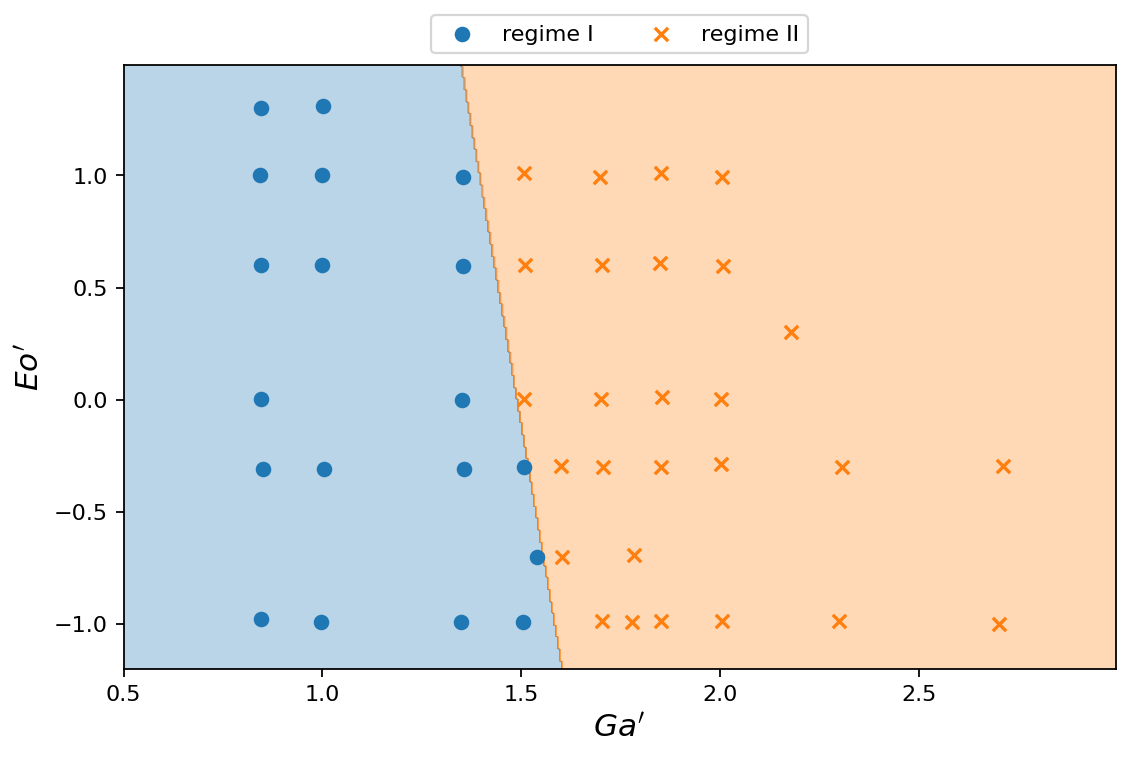

In [18]:
plt.figure(figsize=figsize)
prediction = logClassifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
plt.ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("log_regression_classification.svg")
plt.show()

Great, it works! What you may have observed:

- the loss decreases now monotonically
- the decicion boundary looks slightly better in the sense that some of the points very close to it are a bit farther away now
- the algorithm cloud also converge to the minimum of the loss function if the data was not linearly separable
- we needed more iterations to get to the final weights because the loss gradient decreases with $y-\hat{y}$ as the probabilistic prediction improves

## Non-linear decision boundaries<a id="non_linear_boundaries"></a>

Now we will look at a lightly more complicated case. Region I has two neighboring regions, namely regions II and III. The goal is to separate region I from the other two regions, so it is still a binary classification problem. However, a straight line will not work this time to isolate region I. If you look again at the first plot with all data points of all regions, you may notice that we could draw two lines to solve the problem. The first one will separate region I from region two, and the second one will separate region I from region III. So let's do that first.

In [19]:
# reduced data sets
data_I_II = logData[(logData.regime == "I") | (logData.regime == "II")]
data_I_III = logData[(logData.regime == "I") | (logData.regime == "III")]

# The LabelBinarizer converts the labels "I" to 0 and "II/III" to 1
lb_I_II = preprocessing.LabelBinarizer()
lb_I_III = preprocessing.LabelBinarizer()
lb_I_II.fit(data_I_II.regime)
lb_I_III.fit(data_I_III.regime)

# labels and features
y_I_II = lb_I_II.transform(data_I_II.regime).ravel()
y_I_III = lb_I_III.transform(data_I_III.regime).ravel()
X_I_II = data_I_II[["Ga", "Eo"]].values
X_I_III = data_I_III[["Ga", "Eo"]].values

# classifier to separate region I and II
classifier_I_II = LogClassifier()
classifier_I_II.train(X_I_II, y_I_II, tol=0.1)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(
    classifier_I_II.weights_[0], classifier_I_II.weights_[1], classifier_I_II.weights_[2]))

# classifier to separate region I and III
classifier_I_III = LogClassifier()
classifier_I_III.train(X_I_III, y_I_III, tol=0.05)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(
    classifier_I_III.weights_[0], classifier_I_III.weights_[1], classifier_I_III.weights_[2]))

Training converged after 3021 epochs.
Computed weights: w1=14.3552, w2=1.3521, b=-21.3918
Training converged after 3240 epochs.
Computed weights: w1=5.0926, w2=10.7127, b=-19.6193


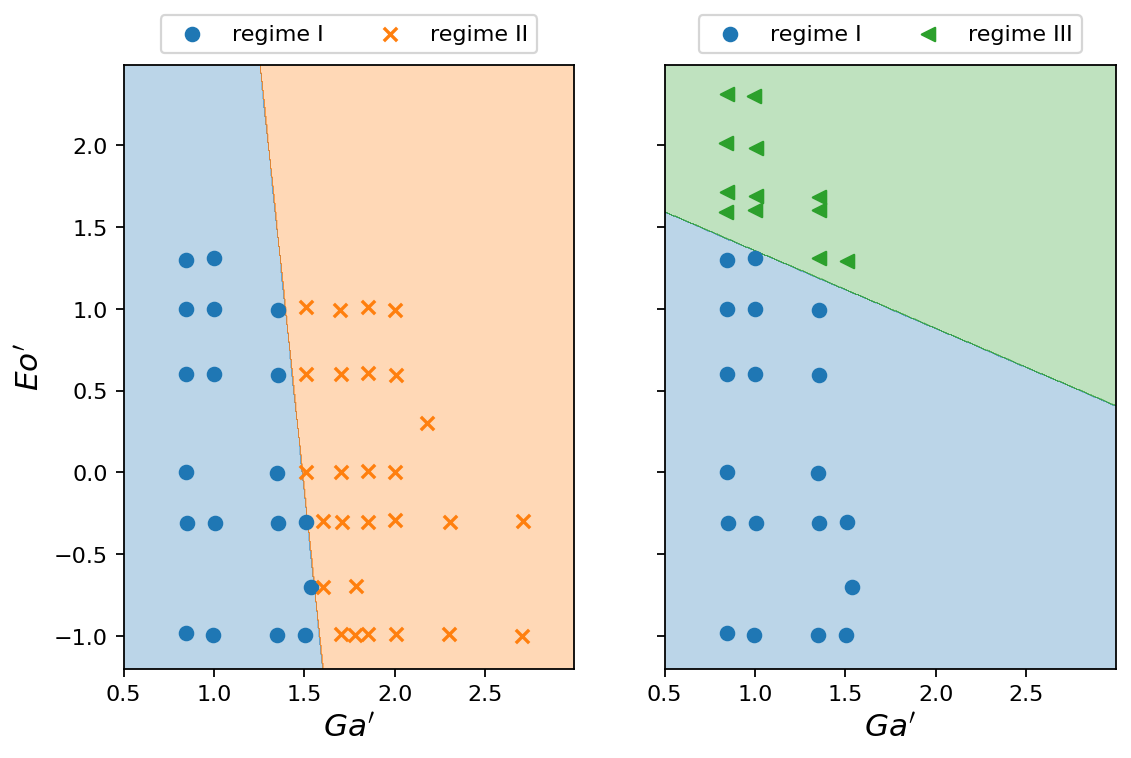

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
xxl, yyl = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 2.5, resolution))

# region I and II
prediction_I_II = classifier_I_II.predict(np.vstack((xxl.ravel(), yyl.ravel())).T)
ax1.contourf(xxl, yyl, prediction_I_II.reshape(xxl.shape), cmap=ListedColormap(["C0", "C1"]), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    ax1.scatter(data_I_II[data_I_II["regime"] == regime].Ga, data_I_II[data_I_II["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))
    
# region I and III
prediction_I_III = classifier_I_III.predict(np.vstack((xxl.ravel(), yyl.ravel())).T)
ax2.contourf(xxl, yyl, prediction_I_III.reshape(xxl.shape), cmap=ListedColormap(["C0", "C2"]), alpha=0.3)
for regime, marker, color in zip(["I", "III"], ["o", "<"], ["C0", "C2"]):
    ax2.scatter(data_I_III[data_I_III["regime"] == regime].Ga, data_I_III[data_I_III["regime"] == regime].Eo,
                marker=marker, color=color, label="regime {}".format(regime))

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
ax1.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
ax2.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
ax1.set_ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("two_binary_classifications.svg")
plt.show()

We have two linear models which allow to isolate region I in two steps. But what if wanted to have a single model doing a single step to solve the problem? How to combine these linear models?

Both models compute probabilities for a point to be __not__ in region one (because they are programmed this way). The simplest way to combine both models is to add their probabilities. We could also weight the linear models or subtract a constant offset. Since the sum of the probabilities can become larger than one, we also need to map them back to the range $0...1$, for example, using the sigmoid function. The new probability for a point to be in region II or III is

$$
  \hat{y}_{i,II,III} = \sigma (w_{21}\hat{y}_{i,II} + w_{22}\hat{y}_{i,III} + b_2) = \sigma (w_{21}\sigma(z_{i,II}) + w_{22}\sigma(z_{i,III}) + b_2)
$$

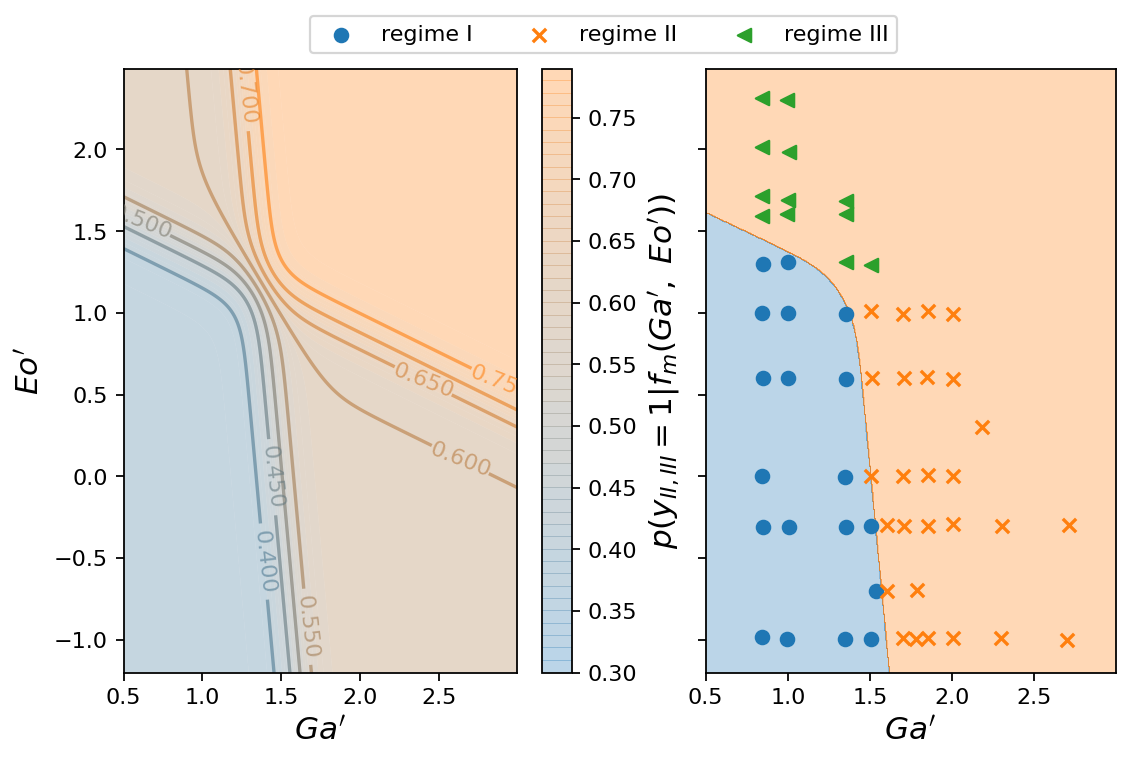

In [21]:
probability_I_II_III = sigmoid(0.9 * classifier_I_II.probability(np.vstack((xxl.ravel(), yyl.ravel())).T)
                             + 0.9 * classifier_I_III.probability(np.vstack((xxl.ravel(), yyl.ravel())).T)
                             - 0.5)
prediction_I_II_III = np.heaviside(probability_I_II_III - 0.5, 0.0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize, gridspec_kw={'width_ratios': [1.2, 1]})

# plot probabilities
cf1 = ax1.contourf(xxl, yyl, probability_I_II_III.reshape(xxl.shape), levels=np.arange(0.3, 0.8, 0.01), cmap=cm, alpha=0.3, antialiased=True)
c1 = ax1.contour(xxl, yyl, probability_I_II_III.reshape(xxl.shape), levels=np.arange(0.3, 0.8, 0.05), cmap=cm, alpha=0.6, antialiased=True)
ax1.clabel(c1, inline=1, fontsize=10)
fig.colorbar(cf1, ax=[ax1]).set_label(r"$p(y_{II,III}=1 | f_m(Ga^\prime,\ Eo^\prime))$", fontsize=fontsize_label)

# plot resulting decicion boundary
ax2.contourf(xxl, yyl, prediction_I_II_III.reshape(xxl.shape), cmap=ListedColormap(['C0', 'C1']), alpha=0.3)

# plot data point for region I and II in subplot 2
for regime, marker in zip(regimes[:3], markers[:3]):
    ax2.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, label="regime {}".format(regime))

ax1.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
ax1.set_ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
ax2.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
conditional_save("nonlinear_classification.svg")
plt.show()

The weighted combination of two linear models piped into a non-linear function (sigmoid) creates a new non-linear model with a more complex decision boundary. If we were to draw a graphical representation of the model function, it might look like the following sketch:

In [22]:
html_string = "<img src=\"combined_linear_models.svg\" style=\"width: 800px\"></img>"
display(HTML(html_string))

## The multi-layer percepton<a id="multi_layer_perceptron"></a>

The function we ended up with is called **Multi-Layer-Perceptron** (MLP) or also vanilla **Neural Network**, and the motivation for this naming can be inferred from the sketch above:

- the function arguments form the nodes in the *input-layer*
- the nodes in the *hidden layer* represent linear models
- the arrows connecting two nodes represent a weight (a function parameter)
- each node sums up its weighted inputs and transforms the sum using a so-called *activation function*, which is the sigmoid function in our case
- the nodes with *1* inside represent bias units (offsets of the linear functions)
- for binary classification, there is exactly one node forming the output layer, which is ultimately the probability $\hat{y}$

Now you could imagine that it is possible to combine more and more linear models in the hidden layer to form very complex decision boundaries. Also, we could add more hidden layers and combine the output of the previous layer to get an even stronger non-linear transformation. In fact, the non-linear transformation obtained by using multiple hidden layers is one of the key concepts for the success and popularity of neural networks. MLPs or neural networks in general with multiple hidden layers are called **Deep Neural Networks** and the weight optimization based on data sets is called **Deep Learning** (sometimes deep learning is also used as a synonym for all the technology and theory around building and training deep neural networks).

## Multi-class classification<a id="multi_class"></a>

### One-hot encoding<a id="one_hot"></a>

In the binary classification problem, we converted our *String* labels into numeric values using a binary encoding:

| original label | numeric label |
|:--------------:|:-------------:|
| I              | 0             |
| II             | 1             |

We can follow the same pattern to convert all the other classes into numeric values:

| original label | numeric label |
|:--------------:|:-------------:|
| I              | 0             |
| II             | 1             |
| III            | 2             |
| IV             | 3             |
| V              | 4             |

Considering what we learned before, there are several problems with such an encoding for multi-class classification. The model should output the probabilities for each class, thus a value between zero and one. Also, the increasing numeric label value suggests a continuous relationship between the different classes which is non-existent. At the latest, when there are more than two neighboring regions, it becomes clear that such an encoding is not practical.

The solution to the encoding problem is to introduce new labels, one for each class (region). Instead of having one label with five classes, one for each region, we expand the data set to five labels with one class per label. This is somewhat similar to looking at the problem as five binary classifications.

| original label | numeric label | $\rightarrow$ | is I? | is II? | is III? | is IV? | is V?|
|:--------------:|:-------------:|:-------------:|:-----:|:------:|:-------:|:------:|:----:|
| I              | 0             | $\rightarrow$ | 1     | 0      | 0       | 0      | 0    |
| II             | 1             | $\rightarrow$ | 0     | 1      | 0       | 0      | 0    |
| III            | 2             | $\rightarrow$ | 0     | 0      | 1       | 0      | 0    |
| IV             | 3             | $\rightarrow$ | 0     | 0      | 0       | 1      | 0    |
| V              | 4             | $\rightarrow$ | 0     | 0      | 0       | 0      | 1    |

This strategy is called **one-hot encoding**. In *PyTorch*, we don't have to create a one-hot encoded label explicitly. The loss function implementation used later on takes numeric labels as an input and creates the encoding for us. What we have to do before, however, is to convert the region labels (*String*) into numeric labels (*int*). The *sklearn* [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) provides exactly this functionality.

In [23]:
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(logData.regime)
sample = logData.regime.sample(5)
for l, ln in zip(sample, le.transform(sample.values)): print("label: {:3s}, numeric label: {:1d}".format(l, ln))

label: II , numeric label: 1
label: II , numeric label: 1
label: III, numeric label: 2
label: II , numeric label: 1
label: I  , numeric label: 0


### Softmax function<a id="softmax"></a>

The generalization of the sigmoid function to multiple classes, returning a probability vector with one probability for each class, is called **softmax function**. For a class $j$ and $K$ classes, softmax is defined as

$$
  p(y_{j}=1 | \mathrm{x}) = \frac{e^{z_{j}}}{\sum_{j=0}^{K-1} e^{z_{j}}}.
$$

Note that we need the softmax function only for the output layer. For the hidden layers, we can use different activation functions like *sigmoid*, *tanh*, *ReLU*, etc. In a binary classification problem, the softmax function turns back into sigmoid.

### Categorical cross entropy<a id="categorial_cross_entropy"></a>

As softmax is the generalization of sigmoid to multiple classes, *categorical cross entropy* is the multi-class extension of binary cross entropy. For each data point $i$ and class $j$, it is defined as

$$
  L(\mathrm{w}) = -\frac{1}{N} \sum\limits_{j=0}^{K-1}\sum\limits_{i=1}^{N} y_{ij} \mathrm{ln}\left( \hat{y}_{ij} \right),
$$

### A note on the implementation in *PyTorch*<a id="note_on_pytorch"></a>

For the final classifier, we will use the popular Deeplearning library [PyTorch](https://pytorch.org/), which comes packed with many useful machine learning algorithms. The following PyTroch-based implementation deviates slightly from the formulas above in that a *log_softmax* function is used while the *NLLLoss* function expects log-probabilities. This distinction is a design choice to avoid the division by small numbers when evaluating the softmax function.

To find the network weights, we use a gradient descent algorithm, enhanced with some empirical rules, called [ADAM](https://arxiv.org/abs/1412.6980). The gradient is computed based on [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD). The basic idea is to employ the [chain-rule](https://en.wikipedia.org/wiki/Chain_rule) until we end up with some simple expressions of which we know the exact derivative. Consider, for example, the function

$$
    f(x) = \mathrm{sin}\left( x^2 \right).
$$

This function could be written as $f(g(x)) = \mathrm{sin}\left( g(x) \right)$ with $g(x)=x^2$. Using the chain rule, we know that the generic derivative w.r.t. $x$ will be

$$
    \frac{\mathrm{d}f}{\mathrm{d}x} = \frac{\mathrm{d}f}{\mathrm{d}g}\frac{\mathrm{d}g}{\mathrm{d}x}.
$$

In an AD framework, every basic function like $\mathrm{sin}(x)$ and $x^n$ is implemented together with its derivative, here $\mathrm{cos}(x)$ and $n x^{n-1}$. Employing the chain rule, we can compute the derivative of any combination of these basic functions automatically. In the example above we get

$$
    \frac{\mathrm{d}f}{\mathrm{d}x} = \mathrm{cos}\left( x^2 \right) 2x
$$

### Splitting data to train/test set
In order to avoid overfitting one common method is split data to train/test set. After training model the model is tested by unseen data in test set. in order to use this method and future use of alternative way lie mini_batch gradient descent a datset loader is defined and will be used to feed data to model.

In [24]:
# Create the data class
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        # convert feature and label arrays into PyTorch tensors
        self.featureTensor = torch.from_numpy(np.float32(logData[["Ga", "Eo"]].values))
        self.labelTensor = torch.tensor(y_numeric, dtype=torch.long)
        self.len = self.featureTensor.shape[0]
    
    # Getter
    def __getitem__(self, index):      
        return self.featureTensor[index], self.labelTensor[index]
    
    # Get length
    def __len__(self):
        return self.len
# instantiate a Data object 
dataset = Data()
# Splitting data to train/validation data 
train_data_size = 0.96
val_data_size = 0.04
train_data_size = round(len(dataset) * train_data_size)
val_data_size = round(len(dataset) * val_data_size)

train_data, val_data = random_split(dataset, [train_data_size, val_data_size], generator=torch.Generator().manual_seed(4))

In [25]:
# Simple MLP built with PyTorch
class PyTorchClassifier(nn.Module):
    '''Multi-layer perceptron with 3 hidden layers.
    '''
    def __init__(self, n_features=2, n_classes=5, n_neurons=60, activation=torch.sigmoid):
        super().__init__()
        self.activation = activation
        self.layer_1 = nn.Linear(n_features, n_neurons)
        self.layer_2 = nn.Linear(n_neurons, n_neurons)
        self.layer_3 = nn.Linear(n_neurons, n_classes)
        
    def forward(self, x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        return F.log_softmax(self.layer_3(x), dim=1)

In [26]:
regimeClassifier = PyTorchClassifier()
# categorial cross entropy taking logarithmic probabilities
criterion = nn.NLLLoss()
# stochastic gradient decent: ADAM
optimizer = optim.Adam(regimeClassifier.parameters(), lr=0.005)

In [27]:
epochs = 1500
train_losses = []
validation_losses = []
trainloader = DataLoader(dataset = train_data, batch_size = train_data_size)
validationloader = DataLoader(dataset = val_data, batch_size = val_data_size)
def train_model(epochs):
    for epoch in range(1, epochs):
        for x, y in trainloader:
            # because of the pytorch wy of calculating grad 
            optimizer.zero_grad()
            # run forward pass through the network
            log_prob = regimeClassifier(x)
            # compute cross entropy
            train_loss = criterion(log_prob, y)
            # compute gradient of the loss function w.r.t. to the model weights
            train_loss.backward()
            # update weights
            optimizer.step()
        # keep track and print progress
        train_losses.append(train_loss.item())
        if epoch % 100 == 0:
            print("Training loss after {} epochs: {}".format(epoch, train_loss.item()))
        
        # feed validation data to trained model 
        for x_val, y_val in validationloader:
            # How model works on test data
            log_prob_val = regimeClassifier(x_val)
            # calculating test data loss
            validation_loss = criterion(log_prob_val, y_val)  
        validation_losses.append(validation_loss.item())
               

train_model(epochs)  

Training loss after 100 epochs: 0.4975202679634094
Training loss after 200 epochs: 0.2974543869495392
Training loss after 300 epochs: 0.22138577699661255
Training loss after 400 epochs: 0.18204905092716217
Training loss after 500 epochs: 0.1517477184534073
Training loss after 600 epochs: 0.1269565224647522
Training loss after 700 epochs: 0.10884121060371399
Training loss after 800 epochs: 0.09341849386692047
Training loss after 900 epochs: 0.07830794155597687
Training loss after 1000 epochs: 0.05513516440987587
Training loss after 1100 epochs: 0.03136015310883522
Training loss after 1200 epochs: 0.01809363253414631
Training loss after 1300 epochs: 0.012104982510209084
Training loss after 1400 epochs: 0.00893796794116497


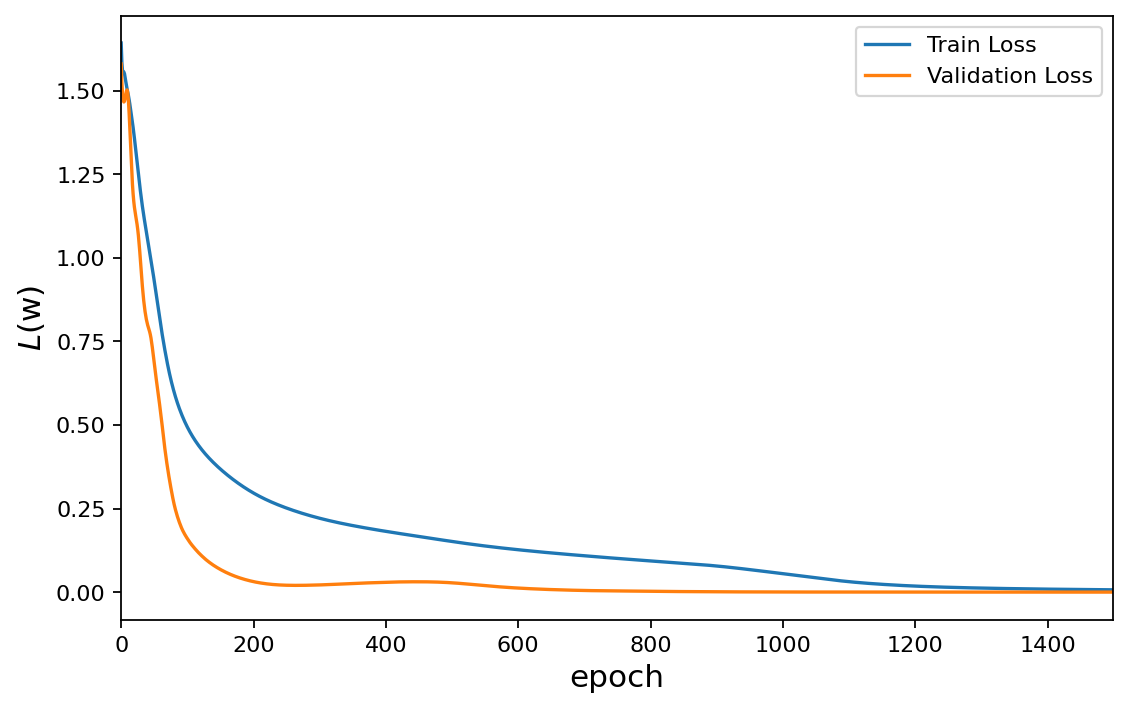

In [28]:
# plot loss over epochs
plt.figure(figsize=figsize)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel(r"epoch", fontsize=fontsize_label)
plt.ylabel(r"$L(\mathrm{w})$", fontsize=fontsize_label)
plt.xlim(0.0, len(train_losses))
plt.legend()
plt.show()

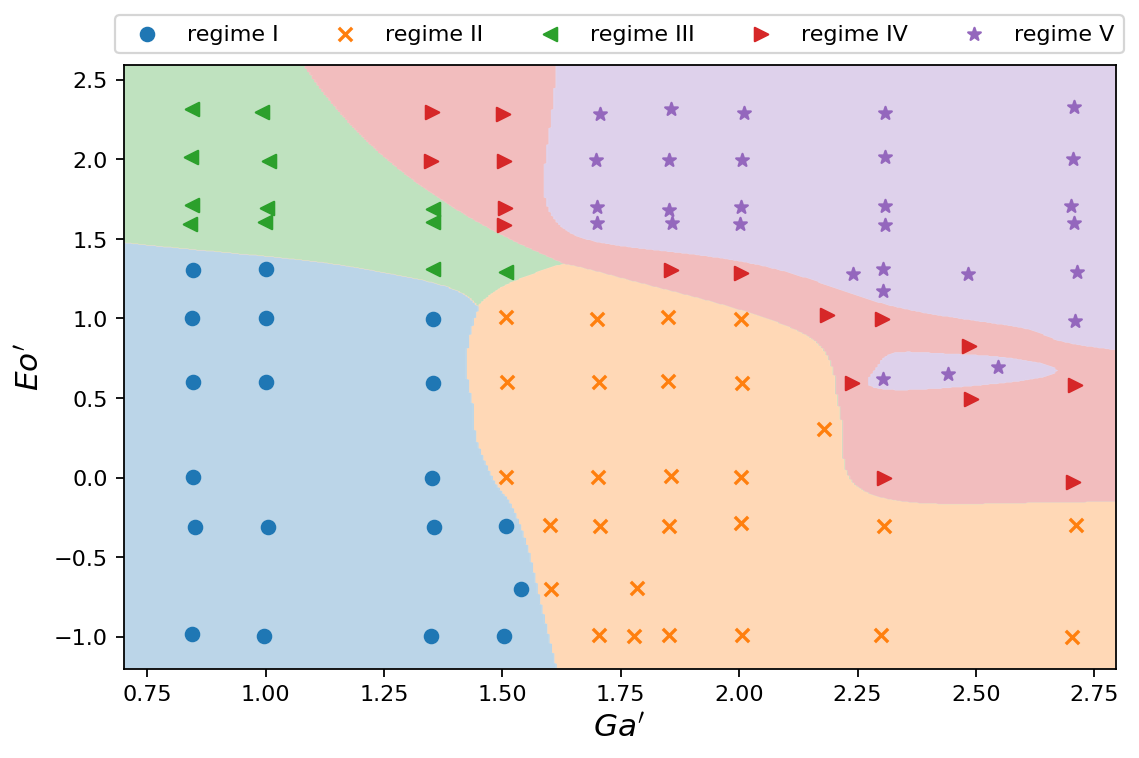

In [29]:
fig, ax = plt.subplots(figsize=figsize)

# color predicted regions
xxf, yyf = np.meshgrid(np.arange(0.7, 2.8, resolution), np.arange(-1.2, 2.6, resolution))
Xf = torch.from_numpy(np.float32(np.vstack((xxf.ravel(), yyf.ravel())).T))
class_prob = regimeClassifier(Xf).exp().detach().numpy()
predictionf = np.argmax(class_prob, axis=1) + 0.01 # addition of small number for plotting
cmap = ListedColormap(["C{:1d}".format(i) for i in range(5)])
ax.contourf(xxf, yyf, predictionf.reshape(xxf.shape), cmap=cmap, alpha=0.3, antialiased=True)

# plot data point for region I and II
for regime, marker in zip(regimes, markers):
    ax.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
               marker=marker, label="regime {}".format(regime))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)
ax.set_xlabel(r"$Ga^\prime$", fontsize=fontsize_label)
ax.set_ylabel(r"$Eo^\prime$", fontsize=fontsize_label)
conditional_save("mlp_classification.svg")
plt.show()

## Final notes<a id="final_notes"></a>

The final result is an extremely powerful model, which could deployed to automate a variety of different processes. However, there are still some points we could improve:

- The training was stopped after the loss decreased below a certain tolerance. Depending on the chosen tolerance, also the final decision boundary will vary. If we have many parameters and train for many epochs, the model can be over-adjusted to the data (over-fitting). In that case, the model will have high accuracy on the training data, but it might not generalize very well to new data points of which we do not know the label.
- A common strategy to avoid over-fitting is to split the dataset in training, validation, and test data. Training and validation data are used to train the model and to check when it starts to over-fit (keywords: cross-validation, early stopping). The test set is not used for training but only for the final evaluation.
- another trick to avoid over-fitting is the addition of a regularization term based on the model weights to the loss function.